#Fashion MNIST

Workflow:
Image data obtain-> preprocessing -> T-T split -> Training the CNN model -> Evaluate -> Streamlit Web App -> Dockerize it (write Docker file -> builds Docker image -> run a Docker container) -> Run app on any machine

In [4]:
!pip install numpy==1.26.3
!pip install tensorflow==2.15.0 --quiet

In [5]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [6]:
# Set seeds for reproducibility of results for comparision (eg. initializing the weights of NN)
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Import dependencies
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Data Curation & Data Processing

In [7]:
fashion_mnist = datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [8]:
type(train_images), len(train_images), len(test_images)

(numpy.ndarray, 60000, 10000)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

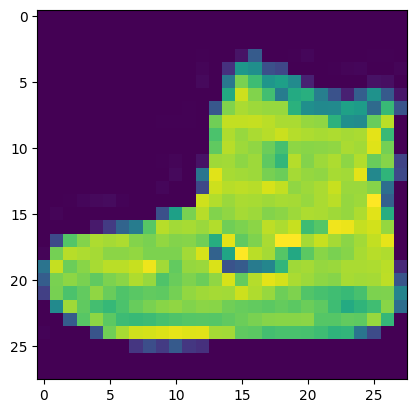

In [9]:
print(train_images[0])
print(train_labels[0])
plt.imshow(train_images[0]) # shape is (28, 28) so greyscale (aka. single channel)

In [10]:
# Normalizing the pixel values (just perf of the model (gradient descent) becomes better,
# ...model wont converge to a local optimum)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape images to specify that it's a single channel
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)) # Last dimension (_, _, _, 1) must be channel info, amke it 3 for RGB image
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

Build & Train Model

In [11]:
# Build the convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10)) # Add 'softmax' and see

# Compile and train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # When False thenn ops inform of probabilities
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [12]:
history = model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 13s 5ms/step - loss: 0.4913 - accuracy: 0.8202 - val_loss: 0.3594 - val_accuracy: 0.8695
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3180 - accuracy: 0.8835 - val_loss: 0.3713 - val_accuracy: 0.8658
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2751 - accuracy: 0.8988 - val_loss: 0.2954 - val_accuracy: 0.8940
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2433 - accuracy: 0.9098 - val_loss: 0.2725 - val_accuracy: 0.8991
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2210 - accuracy: 0.9187 - val_loss: 0.2705 - val_accuracy: 0.9016


Evaluating the Model

313/313 - 1s - loss: 0.2705 - accuracy: 0.9016 - 619ms/epoch - 2ms/step


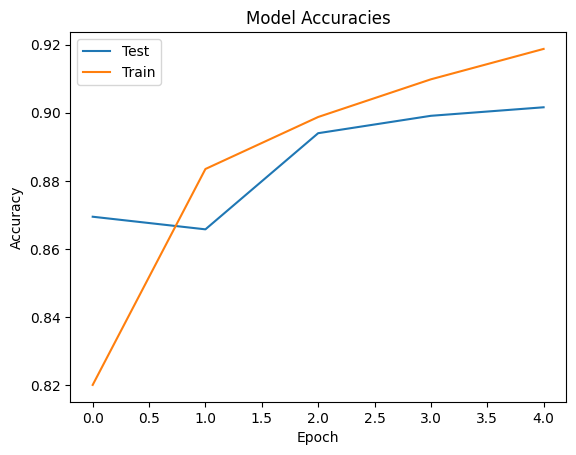

In [13]:
val_accuracy, val_loss = model.evaluate(test_images, test_labels, verbose=2)
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["accuracy"])
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()

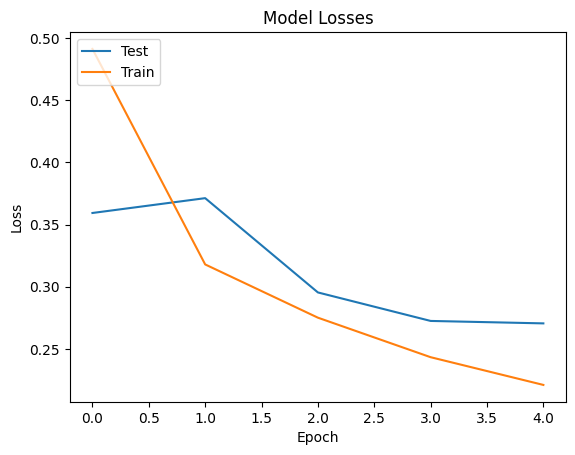

In [14]:
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title('Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()

In [15]:
model.save('trained_fashion_mnist_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
